In [248]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [249]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [250]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [251]:
test_data.info

<bound method DataFrame.info of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Ut

# Import Section

In [252]:
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as skpp
import scipy.stats as stats
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re

from keras.models import Sequential
from keras.layers import BatchNormalization 
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint #we can control our model if going well during validation part or not
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
import tensorflow as tf

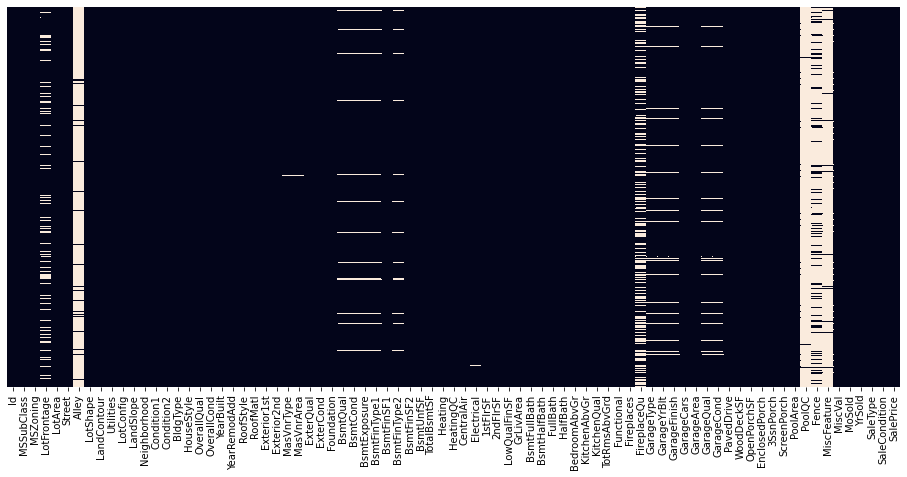

In [253]:
plt.figure(figsize = (16,7))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False)

Dropping the features
BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, 
BsmtFinType2, GarageType, GarageFinish, GarageQual, FireplaceQu, GarageCond -- with "None" 

Total Data in Test Set: 1459

Missing Values in Test Set:

MSZoning:4
LotFrontage:227
Alley:1352
Utilities:2
Exterior1st:1
Exterior2nd:1
MasVnrType:16
MasVnrArea:15
BsmtQual:44
BsmtCond:45
BsmtExposure:44
BsmtFinType1:42
BsmtFinSF1:1
BsmtFinType2:42
BsmtFinSF2:1
BsmtUnfSF:1
TotalBsmtSF:1
BsmtFullBath:2
BsmtHalfBath:2
KitchenQual:1
Functional:2
FireplaceQu:730
GarageType:76
GarageYrBlt:78
GarageFinish:78
GarageCars:1
GarageArea:1
GarageQual:78
GarageCond:78
PoolQC:1456
Fence:1169
MiscFeature:1408
SaleType:1


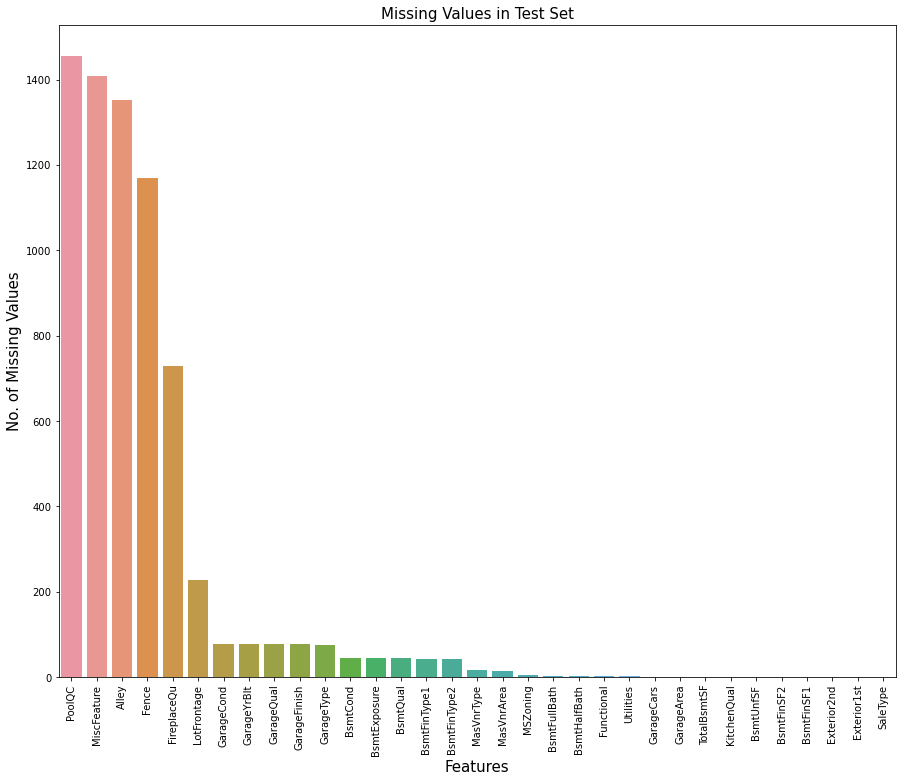

In [254]:
print('Total Data in Test Set:', len(test_data))
print('\nMissing Values in Test Set:\n')
Headings = list(test_data)
MSx = []
MSy = []
for name in Headings:
    if (test_data[name].isnull().sum() > 0):
        print('%s:%d' % (name,test_data[name].isnull().sum()))
        MSx = MSx + [name]
        MSy = MSy + [test_data[name].isnull().sum()]

df = pd.DataFrame(data={'MSx':MSx, 'MSy':MSy})
df = df.sort_values(by=['MSy'], ascending=False)
plt.figure(2, figsize=(15,12))
sns.barplot(x=df.MSx, y=df.MSy)
plt.xticks(rotation='90')
plt.title('Missing Values in Test Set', fontsize=15)
plt.xlabel('Features', fontsize=15)
plt.ylabel('No. of Missing Values', fontsize=15)
plt.show()

In [255]:
NoneCols = ['MiscFeature', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass', 'Alley']

for name in NoneCols:
    train_data[name] = train_data[name].fillna('None')
    test_data[name] = test_data[name].fillna('None')

OCols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
         'BsmtHalfBath', 'MasVnrArea', 'MasVnrArea']

for name in OCols:
    train_data[name] = train_data[name].fillna(0)
    test_data[name] = test_data[name].fillna(0)   
    
MCols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

for name in MCols:
    train_data[name] = train_data[name].fillna(train_data[name].mode()[0])
    test_data[name] = test_data[name].fillna(test_data[name].mode()[0])

train_data['LotFrontage'] = train_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_data['LotFrontage'] = test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test_data['Functional'] = test_data['Functional'].fillna('Typ')

train_data = train_data.drop('Utilities', axis=1)
test_data = test_data.drop('Utilities', axis=1)

if(train_data.isnull().sum().sum() == 0 and test_data.isnull().sum().sum() == 0):
    print('\nNo Missing Values found')
else:
    train_data.isnull().sum()
    print('\nMissing Values are still present')


No Missing Values found


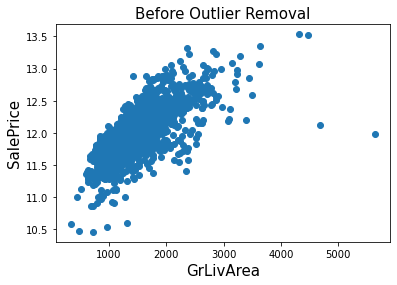

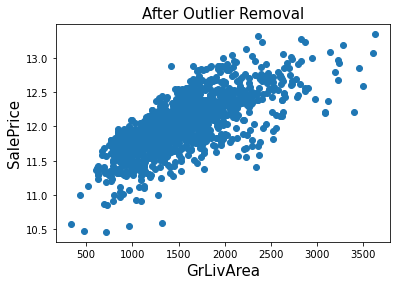

In [257]:
def outlier_detection(train_data):
    # Outlier Detection
    plt.figure(9)
    plt.scatter(x=train_data['GrLivArea'], y=train_data['SalePrice'])
    plt.title('Before Outlier Removal', fontsize=15)
    plt.xlabel('GrLivArea', fontsize=15)
    plt.ylabel('SalePrice', fontsize=15)
    plt.show()
    plt.savefig('Before_Outlier_Removal.png')
    plt.close()
    
    # Outlier Removal
    train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
    train_data = train_data.reset_index()
    train_data = train_data.drop('index', axis=1)

    # Cleaned Data
    plt.figure(10)
    plt.scatter(x=train_data['GrLivArea'], y=train_data['SalePrice'])
    plt.title('After Outlier Removal', fontsize=15)
    plt.xlabel('GrLivArea', fontsize=15)
    plt.ylabel('SalePrice', fontsize=15)

    plt.savefig('After_Outlier_Removal.png')
    plt.show()
    plt.close()
outlier_detection(train_data)


mu(Mean): 12.024
sigma(Standard Deviation): 0.399
Mode: 11


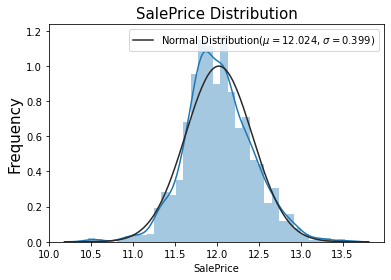

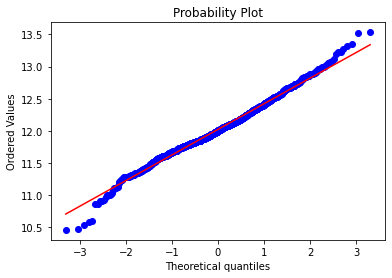

Skewness: 0.12135
Kurtosis: 0.80952

Z-Score: [ 0.56006699  0.21276333  0.73404616 ...  1.17470887 -0.39965728
 -0.30669507]


In [256]:
Y_train = train_data['SalePrice']
Id_final = test_data['Id']
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])

    # New Distribution

    # Mean, Standard Deviation and Mode
(mu, sigma) = stats.norm.fit(train_data['SalePrice'])
mu = round(mu,3)
sigma = round(sigma,3)
mode = int(train_data['SalePrice'].mode())
print('\nmu(Mean):', mu)
print('sigma(Standard Deviation):', sigma)
print('Mode:', mode)

    # Skewness of Target Variable
plt.figure(11)
sns.distplot(train_data['SalePrice'] , fit=stats.norm)
plt.title('SalePrice Distribution', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.legend(['Normal Distribution($\mu=$%.3f, $\sigma=$%.3f)' % (mu,sigma)], loc='best')
plt.show()

    # Probability Plot(Similar to Quantile-Quantile Plot)
plt.figure(12)
stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

    # Skewness and Kurtosis
print('Skewness: %.5f' % train_data['SalePrice'].skew())
print('Kurtosis: %.5f' % train_data['SalePrice'].kurt())

    # Z-Score
Zscore = stats.zscore(train_data['SalePrice'])
print('\nZ-Score:', Zscore)


In [258]:
Train_fe = train_data.copy()
Test_fe = test_data.copy()


print('\nMost important features relative to Target:\n')
CMtx = Train_fe.corr()
CMtx.sort_values(['SalePrice'], ascending = False, inplace = True)
print(CMtx['SalePrice'][abs(CMtx['SalePrice']) >= 0.1])


Train_fe['HsAge'] = Train_fe['YrSold'] - Train_fe['YearBuilt']
Test_fe['HsAge'] = Test_fe['YrSold'] - Test_fe['YearBuilt']
Train_fe['TotalSF'] = Train_fe['TotalBsmtSF'] + Train_fe['1stFlrSF'] + Train_fe['2ndFlrSF']
Test_fe['TotalSF'] = Test_fe['TotalBsmtSF'] + Test_fe['1stFlrSF'] + Test_fe['2ndFlrSF']


Train_fe['MSSubClass'] = Train_fe['MSSubClass'].apply(str)
Test_fe['MSSubClass'] = Test_fe['MSSubClass'].apply(str)
Train_fe['OverallCond'] = Train_fe['OverallCond'].astype(str)
Test_fe['OverallCond'] = Test_fe['OverallCond'].astype(str)
Train_fe['MoSold'] = Train_fe['MoSold'].astype(str)   
Test_fe['MoSold'] = Test_fe['MoSold'].astype(str)



cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'GarageType', 'MiscFeature', 
        'SaleType', 'SaleCondition', 'Electrical', 'Heating')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(Train_fe[c].values)) 
    Train_fe[c] = lbl.transform(list(Train_fe[c].values))
    
    lbl.fit(list(Test_fe[c].values)) 
    Test_fe[c] = lbl.transform(list(Test_fe[c].values))



"""
    for column in OrdCols:
     Train
    lbl = skpp.LabelEncoder() 
    lbl.fit(list(Train_fe[column].values))
    Train_fe[column] = lbl.transform(list(train_data[column].values))
    #encoder=LabelEncoder()
    #Train_fe= train_data.apply(lambda col: encoder.fit_transform(col.astype(str)), axis=0, result_type='expand')
  
    # Test
    #lbl = skpp.LabelEncoder() 
    #lbl.fit(list(Test_fe[column].values))
    #Test_fe[column] = lbl.transform(list(Test_fe[column].values))
    #encoder=LabelEncoder()
    #Test_fe= test_data.apply(lambda col: encoder.fit_transform(col.astype(str)), axis=0, result_type='expand')
"""  
    
    
    
NumF = Train_fe.dtypes[Train_fe.dtypes != 'object'].index
NumF = NumF.drop('SalePrice')


SkewedFtrn = Train_fe[NumF].apply(lambda x: x.skew()).sort_values(ascending=False)
print("\nSkewness in Numerical Features(Train): \n")
df = pd.DataFrame({'Skewness' : SkewedFtrn})
print(df.head(15))


SkewedFtst = Test_fe[NumF].apply(lambda x: x.skew()).sort_values(ascending=False)
print("\nSkewness in Numerical Features(Test): \n")
df = pd.DataFrame({'Skewness' : SkewedFtst})
print(df.head(15))

Tolerance = 0.2 
BoxF = list(SkewedFtrn[abs(SkewedFtrn) > Tolerance].index) + list(SkewedFtst[abs(SkewedFtst) > Tolerance].index)
BoxF = list(set(BoxF))
Lam = 0.15  
for name in BoxF:
    Train_fe[name] = boxcox1p(Train_fe[name], Lam)
    Test_fe[name] = boxcox1p(Test_fe[name], Lam)

DF = list(CMtx.index[abs(CMtx['SalePrice']) < 0.02])
Train_fe.drop(DF, axis=1, inplace=True)
Test_fe.drop(DF, axis=1, inplace=True)

#Features that have a very low Correlation with the Target Variable were dropped.


Most important features relative to Target:

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.426776
BsmtFinSF1       0.372023
LotFrontage      0.353288
GarageYrBlt      0.349013
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64

Skewness in Numerical Features(Train): 

                Skewness
MiscVal        24.476794
PoolArea       14.828374
Condition2     13.171844
LotArea        12.207688
3SsnPorch      10.304342
Heating         9.855100
Low

In [259]:
Train_fey = Train_fe['SalePrice']
Train_fe = Train_fe.drop('SalePrice', axis=1)
dataFE = pd.concat((Train_fe, Test_fe)).reset_index(drop=True)

# Column Treatment(One Hot Encoding of Categorical Data)
dataFE = pd.get_dummies(dataFE)
print('\nShape of Data:')
print(dataFE.shape)


#train_set_size = int(.67 * len(X_train))
# Data Separation


X_train = dataFE[:1460]
X_test = dataFE[1460:]
X_test = X_test.reset_index().drop('index', axis=1)


Shape of Data:
(2919, 78)


In [260]:
model = Sequential()

model.add(Dense(units=512, activation='linear'))
model.add(BatchNormalization())
model.add(Dense(units=512, activation='linear'))
model.add(BatchNormalization())
model.add(Dense(units=512, activation='linear'))
model.add(BatchNormalization())
model.add(Dense(units=256, activation='linear'))
model.add(BatchNormalization())
model.add(Dense(units=128, activation='linear'))
model.add(BatchNormalization())
model.add(Dense(units=128, activation='linear'))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='linear'))
lr = .001
adam0 = Adam(lr = lr)

model.compile(loss='mean_squared_error',
               optimizer=adam0, metrics = ['accuracy']) 
filepath = 'weights.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_model = model.fit(X_train, Train_fey,callbacks=callbacks_list, validation_split=0.2, epochs=5000, batch_size=128, verbose=0)
predict = model.predict(X_test, batch_size=128) 

pred = np.exp(predict).flatten()
pred = pd.DataFrame({'Id':Id_final, 'SalePrice':pred})
pred['SalePrice'] = pred['SalePrice'].transform(lambda x: (x-1))

pred.to_csv('submission.csv', index=False)

KeyboardInterrupt: 